# Loading code and data

## When loading notebook for the first time:

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
!mkdir /root/.kaggle

In [11]:
########################################
########## Add kaggle API key ##########
########################################

!echo '{"username":"aliceallafort","key":"0d34479935dac419278ed5dce8d32974"}' > ~/.kaggle/kaggle.json

In [12]:
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!git clone https://github.com/TigerManon/drive-on-mars.git

Cloning into 'drive-on-mars'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 220 (delta 37), reused 49 (delta 29), pack-reused 144
Receiving objects: 100% (220/220), 25.85 MiB | 9.42 MiB/s, done.
Resolving deltas: 100% (82/82), done.


In [5]:
%cd drive-on-mars/
%mkdir raw_data
%cd raw_data

/content/drive-on-mars
/content/drive-on-mars/raw_data


In [13]:
!kaggle datasets download yash92328/ai4mars-terrainaware-autonomous-driving-on-mars

100% 5.72G/5.72G [04:58<00:00, 25.2MB/s]
100% 5.72G/5.72G [04:58<00:00, 20.6MB/s]


In [14]:
!unzip -q ai4mars-terrainaware-autonomous-driving-on-mars.zip

In [15]:
!rm ai4mars-terrainaware-autonomous-driving-on-mars.zip

In [16]:
%cd ../

/content/drive-on-mars


In [17]:
%ls

 dockerfile       Jinjin_draft.ipynb   README.md         'U-Net pretrained.ipynb'
 drive_on_mars/   notebooks/           requirements.txt  'U-Net Test-Copy1.ipynb'
 First_model.h5   raw_data/            setup.py           Untitled.ipynb


## When reloading the notebook

In [ ]:
%ls

In [ ]:
%pwd

'/content'

In [ ]:
%cd drive-on-mars/

/content/drive-on-mars


sample_data/


# Loading Libraries


In [18]:
#!pip install git+https://github.com/qubvel/segmentation_models
!pip install segmentation_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.6 MB/s eta 0:00:00


In [19]:
# Data Visualisation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tqdm import tqdm


from tensorflow.keras import callbacks
from sklearn.model_selection import train_test_split


In [20]:
# Segmentation Models

############# Alice #################
# Had to add this to make sm work in colab
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow import keras
import segmentation_models as sm
#####################################

import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf


Segmentation Models: using `tf.keras` framework.


# DeepLabV3_ResNet50 Model Tuning


## Data Generator for DeepLab_Res50_Model

In [ ]:
#image_folder = "raw_data/ai4mars-dataset-merged-0.1/msl/images/edr"
#label_folder = "raw_data/ai4mars-dataset-merged-0.1/msl/labels/train"

In [ ]:
# 0 - soil
# 1 - bedrock
# 2 - sand
# 3 - big rock
# 255 -> 4 - NULL (no label)

In [21]:
# Define a customized data generator
class UnetDataGenerator(keras.utils.Sequence):
    def __init__(self, image_folder, label_folder, input_shape, batch_size, num_classes, subfolder, split_percent):
        self.image_folder       = image_folder
        self.label_folder       = label_folder
        self.input_shape        = input_shape
        self.batch_size         = batch_size
        self.num_classes        = num_classes
        self.subfolder          = subfolder
        self.split_percent      = split_percent
        self.path_df            = self.make_df()
        self.split_df()

    def __len__(self):
        print("Length of generator:", len(self.path_df))
        return math.ceil(len(self.path_df) / float(self.batch_size))

    def make_df(self):
        img_list = [f for f in os.listdir(self.image_folder) if f.endswith('.JPG')]
        lab_list = [f for f in os.listdir(self.label_folder) if f.endswith('.png')]

        path_df = pd.DataFrame(columns=["image_path","label_path"])

        for label_name in lab_list:
            image_name = label_name.replace('.png', '.JPG')
            if image_name in img_list:
                path_df = path_df.append({
                    "image_path": os.path.join(self.image_folder, image_name),
                    "label_path": os.path.join(self.label_folder, label_name)
                }, ignore_index=True)
        return path_df

    def split_df(self):
        if self.subfolder == "train":
            self.path_df = self.path_df.iloc[:int(len(self.path_df) * self.split_percent)]
        elif self.subfolder == "val":
            self.path_df = self.path_df.iloc[int(len(self.path_df) * self.split_percent):]


    def __getitem__(self, index):
        input_images  = []
        output_targets = []

        #-------------------------------#
        #   Calculate start indice and end indice of the batch
        #-------------------------------#
        start = index * self.batch_size
        end = min((index + 1) * self.batch_size, len(self.path_df)) # Make sure that we can load all the data of the last batch

        for i in range(start, end):

            #-------------------------------#
            #   Get image path and label path of each batch from path_df
            #-------------------------------#
            jpg = self.path_df.iloc[i]["image_path"]
            png = self.path_df.iloc[i]["label_path"]

            #-------------------------------#
            #   Transform images and labels to numpy array, resize them
            #   Set the background label to 4
            #-------------------------------#

            jpg = cv2.imread(jpg)
            png = cv2.imread(png,0)

            jpg = cv2.resize(jpg, dsize = (int(self.input_shape[0]), int(self.input_shape[1])))
            png = cv2.resize(png, dsize = (int(self.input_shape[0]), int(self.input_shape[1])),
                                      interpolation = cv2.INTER_NEAREST)

            png[png == 255] = 4

            #-------------------------------------------------------#
            #   One hot encode the labels
            #-------------------------------------------------------#

            seg_labels = np.eye(self.num_classes)[png.reshape([-1])]
            seg_labels = seg_labels.reshape((int(self.input_shape[0]), int(self.input_shape[1]), self.num_classes))

            input_images.append(jpg)
            output_targets.append(seg_labels)

        input_images = np.asarray(input_images)
        output_targets = np.array(output_targets)


        return input_images, output_targets




In [22]:
# image and label directories paths

image_folder = "raw_data/ai4mars-dataset-merged-0.1/msl/images/edr"
label_folder = "raw_data/ai4mars-dataset-merged-0.1/msl/labels/train"

In [23]:
# Some inputs
batch_size = 16
num_classes = 5
input_shape = (256,256,3)
split_percent = 0.8
height=input_shape[0]
width=input_shape[1]
channels=input_shape[2]

In [24]:
%%time
# Train dataset generator and validation dataset generator
traingen = UnetDataGenerator(image_folder,
                             label_folder,
                             input_shape,
                             batch_size,
                             num_classes,
                             "train",
                             split_percent)

valgen = UnetDataGenerator(image_folder,
                           label_folder,
                           input_shape,
                           batch_size,
                           num_classes,
                           "val",
                           split_percent)

Streaming output truncated to the last 5000 lines.
<ipython-input-21-99ef8a345714>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
<ipython-input-21-99ef8a345714>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
<ipython-input-21-99ef8a345714>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
<ipython-input-21-99ef8a345714>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
<ipython-input-21-99ef8a345714>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conc

CPU times: user 47.7 s, sys: 1.66 s, total: 49.4 s
Wall time: 48.4 s


<ipython-input-21-99ef8a345714>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
<ipython-input-21-99ef8a345714>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
<ipython-input-21-99ef8a345714>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
<ipython-input-21-99ef8a345714>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
<ipython-input-21-99ef8a345714>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  path_df = path_df.append({
<ipython-i

## DeepLab_ResNet50 Model Initialization


In [25]:
NUM_CLASSES = 5
IMAGE_SIZE = 256

In [26]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=(3, 3),
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation="nearest",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [27]:
# Use a ResNet50 pretrained on ImageNet as the backbone model
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    preprocessed = preprocess_input(model_input)
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=preprocessed
    )

    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="nearest",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="nearest",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


deep_model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
deep_model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 tf.__operators__.getitem (  (None, 256, 256, 3)          0         ['input_1[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.nn.bias_add (TFOpLambda  (None, 256, 256, 3)          0         ['tf.__operators__.getitem[0][
 )                                                                  0]']                          
                             

In [28]:
loss = 'CategoricalCrossentropy'
metrics=['accuracy', iou_score]
deep_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=loss,
    metrics=metrics,
)

## DeepLab_ResNet50 Model Training

In [29]:
%%time
MODEL = "DeepLab_Res50_ImageNet_img_256pix"

modelCheckpoint = callbacks.ModelCheckpoint("{}.h5".format(MODEL),
                                            monitor="val_iou_score",
                                            save_best_only = False)

LR_reducer = callbacks.ReduceLROnPlateau(patience = 3,
                                         monitor="val_iou_score",
                                         factor = 0.1,
                                         min_lr = 0
                                        )

early_stopper = callbacks.EarlyStopping(patience = 5,
                                        monitor="val_iou_score",
                                        restore_best_weights=True)



deep_history = deep_model.fit(traingen,
          validation_data=valgen,
          epochs=100,
          callbacks = [modelCheckpoint, LR_reducer, early_stopper],
          verbose=1)


Length of generator: 3213
Length of generator: 12851
Length of generator: 12851
Epoch 1/100
Length of generator: 12851
804/804 [==============================] - ETA: 0s - loss: 2.4261 - accuracy: 0.1983 - iou_score: -0.0480Length of generator: 3213
Length of generator: 3213
Length of generator: 3213
Length of generator: 3213


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


804/804 [==============================] - 324s 353ms/step - loss: 2.4261 - accuracy: 0.1983 - iou_score: -0.0480 - val_loss: 2.0836 - val_accuracy: 0.0798 - val_iou_score: 1.4786 - lr: 1.0000e-04
Length of generator: 12851
Epoch 2/100
Length of generator: 12851
804/804 [==============================] - ETA: 0s - loss: 2.5057 - accuracy: 0.1840 - iou_score: 0.2147Length of generator: 3213
Length of generator: 3213
Length of generator: 3213
804/804 [==============================] - 282s 351ms/step - loss: 2.5057 - accuracy: 0.1840 - iou_score: 0.2147 - val_loss: 3.0142 - val_accuracy: 0.1383 - val_iou_score: -0.0085 - lr: 1.0000e-04
Length of generator: 12851
Epoch 3/100
Length of generator: 12851
804/804 [==============================] - ETA: 0s - loss: nan - accuracy: 0.1616 - iou_score: nanLength of generator: 3213
Length of generator: 3213
Length of generator: 3213
804/804 [==============================] - 287s 357ms/step - loss: nan - accuracy: 0.1616 - iou_score: nan - val_los

In [30]:
deep_history.history

{'loss': [2.42612624168396, 2.5056939125061035, nan, nan, nan, nan, nan],
 'accuracy': [0.19834032654762268,
  0.1840207278728485,
  0.1616271585226059,
  0.20678992569446564,
  0.20678989589214325,
  0.2067900002002716,
  0.2067900002002716],
 'iou_score': [-0.047954026609659195,
  0.21472029387950897,
  nan,
  nan,
  nan,
  nan,
  nan],
 'val_loss': [2.0836451053619385, 3.0142416954040527, nan, nan, nan, nan, nan],
 'val_accuracy': [0.07984408736228943,
  0.1382778435945511,
  0.2073272317647934,
  0.2073272317647934,
  0.2073272317647934,
  0.2073272317647934,
  0.2073272317647934],
 'val_iou_score': [1.478609323501587,
  -0.008478347212076187,
  nan,
  nan,
  nan,
  nan,
  nan],
 'lr': [1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-05, 1e-05]}

In [ ]:
def plot_history(deep_history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(deep_history.history['loss'], label = 'train' + exp_name)
    ax1.plot(deep_history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(deep_history.history['iou_score'], label='train iou'  + exp_name)
    ax2.plot(deep_history.history['val_iou_score'], label='val iou'  + exp_name)
    ax2.set_ylim(0, 0.7)
    ax2.set_title('iou')
    ax2.legend()
    plt.show()

plot_history(deep_history)

## DeepLab_ResNet50 Model Saving

In [ ]:
!mkdir raw_data/models
!ls raw_data

mkdir: cannot create directory ‘raw_data/models’: File exists
ai4mars-dataset-merged-0.1  models


In [ ]:
deep_model.save(f'raw_data/models/{MODEL}.h5')

In [ ]:
!ls raw_data/models

unet_4deep_16in_whole_data_img_256pix.h5	 Unet_ResBackBone_ImageNet_img_256pix.h5
unet_4deep_16in_whole_data_img_scaled_256pix.h5


In [ ]:

%cp raw_data/models/DeepLab_Res50_ImageNet_img_256pix.h5 /content/drive/MyDrive/data/models

## Training Records

09/12/2023 23:34




*   Model: unet_4deep_16in_256pix
*   optimizer: 'adam', loss: sm.losses.bce_jaccard_loss, metrics: sm.metrics.
    iou_score
*   Trainable params: 1941173
*   Data: 12851 train images; 3213 val images, loaded,preporcessed,splited by   
      UnetDataGenerator
*   Training: set up for 100 epochs, stopped at 6 epochs by early stopping,
    Wall time: 29min 52s, GPU V100
*   'loss': 0.5861780643463135,
    'iou_score': 0.5779913663864136,
    'val_loss':  0.5868656635284424],
    'val_iou_score': 0.5775318145751953,
    'lr': [0.001, 0.001, 0.001, 0.001, 0.000100000005, 0.000100000005]





10/12/2023 03:34

* Model: unet_4deep_16in_1024pix

* optimizer: 'adam', loss: sm.losses.bce_jaccard_loss, metrics: sm.metrics.
  iou_score
* Trainable params: 1941173
* Data: image and label size: 1024, 12851 train images; 3213 val images, loaded, preporcessed,splited by UnetDataGenerator
* Training: set up for 100 epochs, stopped at 6 epochs by early stopping,        Wall time: 2h 8min 6s, GPU V100
* 'loss':  0.6727234125137329, 'iou_score': 0.50568687915802, 'val_loss': 0.6704270839691162, 'val_iou_score': 0.5068952441215515, 'lr': [0.001, 0.001, 0.001, 0.001, 0.000100000005, 0.000100000005]




10/12/2023 10:34

* Model: unet_4deep_64in_256pix

* optimizer: 'adam', loss: sm.losses.bce_jaccard_loss, metrics: sm.metrics. iou_score

* Trainable params: 31032005

* Data: image and label size: 256, 12851 train images; 3213 val images, loaded, preporcessed,splited by UnetDataGenerator

* Training: set up for 100 epochs, stopped at 6 epochs by early stopping, Wall time: 29min 3s, GPU A100

* 'loss': 0.5815900564193726, 'iou_score': 0.580341637134552, 'val_loss': 0.59281826019287112, 'val_iou_score': 0.5689619183540344, 'lr': [0.001, 0.001, 0.001, 0.001, 0.000100000005, 0.000100000005] Slightly overfitted

10/12/2023 16:34

* Model: Unet_ResBackBone_ImageNet_img_256pix

* optimizer: 'adam', loss: sm.losses.bce_jaccard_loss, metrics: sm.metrics. iou_score

* Total params: 24456734 (93.30 MB)
Trainable params: 24439384 (93.23 MB)
Non-trainable params: 17350 (67.77 KB)

* Data: image and label size: 256, 12851 train images; 3213 val images, loaded, preporcessed,splited by UnetDataGenerator

* Training: set up for 100 epochs, stopped at 6 epochs by early stopping, Wall time: 27min 3s, GPU A100

* 'loss': 0.4621942937374115
 'accuracy': 0.8795599341392517
 'iou_score': 0.659989595413208
 'val_loss': 0.48931652307510376
 'val_accuracy':  0.8699352741241455
 'val_iou_score': 0.6389757394790649
 'lr': [0.001, 0.001, 0.001, 0.001, 0.000100000005, 0.000100000005]}


10/12/2023 18:34

* Model: Unet_ResBackBone_ImageNet_img_256pix

* optimizer: 'adam', loss:'categorical_crossentropy', metrics: accuracy, iou_score

* Total params: 24456734 (93.30 MB)
Trainable params: 24439384 (93.23 MB)
Non-trainable params: 17350 (67.77 KB)

* Data: image and label size: 256, 12851 train images; 3213 val images, loaded, preporcessed,splited by UnetDataGenerator

* Training: set up for 100 epochs, stopped at 6 epochs by early stopping, Wall time: 30min, GPU A100

* 'loss': 0.28132763504981995
 'accuracy': 0.8859129548072815
 'iou_score': 0.5797572731971741
 'val_loss': 0.31182384490966797
 'val_accuracy':  0.8733996152877808
 'val_iou_score': 0.5677776336669922
 'lr': [0.001, 0.001, 0.001, 0.001, 0.000100000005, 0.000100000005]


## History

In [ ]:
# %%time
# es = callbacks.EarlyStopping(patience=2,restore_best_weights=True)
# #modelCheckpoint = callbacks.ModelCheckpoint("{}.h5".format('First_model'), monitor="val_loss", verbose=0, save_best_only=False)


# history = model.fit(X_train, y_train,
#           batch_size=16,
#           epochs=10,
#           validation_split=0.3,
#           callbacks=[es],
#           verbose=1)


Epoch 1/10
16/16 [==============================] - 26s 1s/step - loss: 1.4578 - iou_score: 0.0815 - val_loss: 1.2656 - val_iou_score: 0.0958
Epoch 2/10
16/16 [==============================] - 23s 1s/step - loss: 1.2874 - iou_score: 0.1014 - val_loss: 1.2581 - val_iou_score: 0.0978
Epoch 3/10
16/16 [==============================] - 24s 2s/step - loss: 1.2503 - iou_score: 0.1036 - val_loss: 1.2078 - val_iou_score: 0.1063
Epoch 4/10
16/16 [==============================] - 24s 2s/step - loss: 1.2265 - iou_score: 0.1115 - val_loss: 1.1993 - val_iou_score: 0.1112
Epoch 5/10
16/16 [==============================] - 24s 2s/step - loss: 1.2203 - iou_score: 0.1126 - val_loss: 1.2105 - val_iou_score: 0.1098
Epoch 6/10
16/16 [==============================] - 24s 1s/step - loss: 1.2093 - iou_score: 0.1202 - val_loss: 1.1699 - val_iou_score: 0.1257
Epoch 7/10
16/16 [==============================] - 24s 2s/step - loss: 1.1916 - iou_score: 0.1295 - val_loss: 1.1409 - val_iou_score: 0.1381
Epoch 

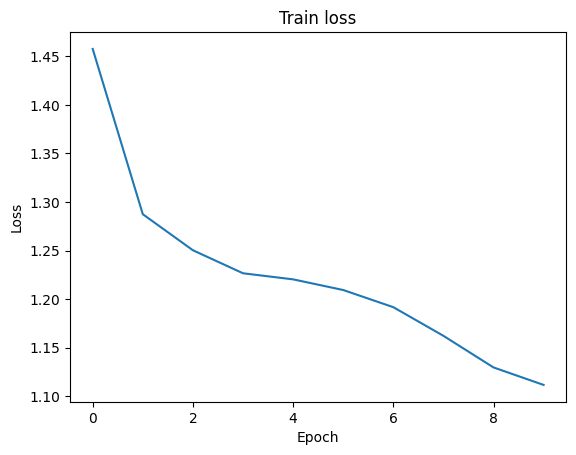

In [ ]:
# plot_history(history)

In [ ]:
%%time
es = callbacks.EarlyStopping(patience=2,restore_best_weights=True)
#modelCheckpoint = callbacks.ModelCheckpoint("{}.h5".format('First_model'), monitor="val_loss", verbose=0, save_best_only=False)


history = model.fit(X_train, y_train,
          batch_size=16,
          epochs=100,
          validation_split=0.3,
          callbacks=[es],
          verbose=1)

Epoch 1/100
16/16 [==============================] - 24s 1s/step - loss: 1.1298 - iou_score: 0.1686 - val_loss: 1.1122 - val_iou_score: 0.1594
Epoch 2/100
16/16 [==============================] - 21s 1s/step - loss: 1.0876 - iou_score: 0.1826 - val_loss: 1.1037 - val_iou_score: 0.1642
Epoch 3/100
16/16 [==============================] - 21s 1s/step - loss: 1.0782 - iou_score: 0.1859 - val_loss: 1.1144 - val_iou_score: 0.1632
Epoch 4/100
16/16 [==============================] - 22s 1s/step - loss: 1.0691 - iou_score: 0.1947 - val_loss: 1.1006 - val_iou_score: 0.1652
Epoch 5/100
16/16 [==============================] - 22s 1s/step - loss: 1.0615 - iou_score: 0.1987 - val_loss: 1.0589 - val_iou_score: 0.1860
Epoch 6/100
16/16 [==============================] - 22s 1s/step - loss: 1.0442 - iou_score: 0.2079 - val_loss: 1.0723 - val_iou_score: 0.1840
Epoch 7/100
16/16 [==============================] - 22s 1s/step - loss: 1.0355 - iou_score: 0.2171 - val_loss: 1.0453 - val_iou_score: 0.1932

In [ ]:
history.history

{'loss': [1.1297701597213745,
  1.0876463651657104,
  1.0782088041305542,
  1.0690951347351074,
  1.0615358352661133,
  1.0441967248916626,
  1.0354652404785156,
  1.0449689626693726,
  1.0198251008987427],
 'iou_score': [0.1685541868209839,
  0.18260574340820312,
  0.18585895001888275,
  0.19469091296195984,
  0.19866147637367249,
  0.20785057544708252,
  0.2171015739440918,
  0.2078864872455597,
  0.21589668095111847],
 'val_loss': [1.1121928691864014,
  1.1037356853485107,
  1.1143794059753418,
  1.1005871295928955,
  1.0588997602462769,
  1.0723048448562622,
  1.04526686668396,
  1.0609480142593384,
  1.080163836479187],
 'val_iou_score': [0.15940341353416443,
  0.1642206758260727,
  0.16320741176605225,
  0.16516396403312683,
  0.18596236407756805,
  0.18400494754314423,
  0.1931913048028946,
  0.1878410279750824,
  0.17755672335624695]}

<function matplotlib.pyplot.show(close=None, block=None)>

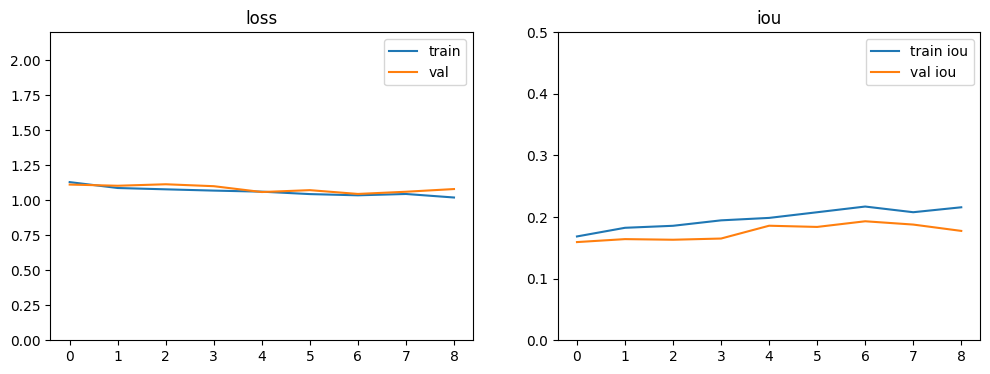

In [ ]:
# def plot_history(history, title='', axs=None, exp_name=""):
#     if axs is not None:
#         ax1, ax2 = axs
#     else:
#         f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

#     if len(exp_name) > 0 and exp_name[0] != '_':
#         exp_name = '_' + exp_name
#     ax1.plot(history.history['loss'], label = 'train' + exp_name)
#     ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
#     ax1.set_ylim(0., 2.2)
#     ax1.set_title('loss')
#     ax1.legend()

#     ax2.plot(history.history['iou_score'], label='train iou'  + exp_name)
#     ax2.plot(history.history['val_iou_score'], label='val iou'  + exp_name)
#     ax2.set_ylim(0, 0.5)
#     ax2.set_title('iou')
#     ax2.legend()
#     return (ax1, ax2)

# plot_history(history)
# plt.show

In [ ]:
print(1)